In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import struct
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
# download MNIST dataset
# run one time only
# data_files = [
#     'train-images-idx3-ubyte.gz',
#     'train-labels-idx1-ubyte.gz',
#     't10k-images-idx3-ubyte.gz',
#     't10k-labels-idx1-ubyte.gz',
# ]
# url = "https://yann.lecun.com/exdb/mnist"
# for f in data_files:
#     r = requests.get(f"{url}/{f}", stream=True)
#     open(f"data/{f.split('.')[0]}.mnist", "wb").write(r.content)

In [3]:
# src: https://www.kaggle.com/code/abdullahtursun/recognizing-digits-using-cnn-98-accuracy
def load_image_file(file_path):
    with open(file_path, "rb") as file:    
        file.read(16)    # Skip the header for images
        binary_data = file.read()
        numpy_data = np.frombuffer(binary_data, dtype=np.uint8)
        num_images = numpy_data.size // 784 
        data = numpy_data.reshape(num_images, 784)
        return data

def load_label_file(file_path):
    with open(file_path, "rb") as file:    
        file.read(16)    # Skip the header for images
        binary_data = file.read()
        data = np.frombuffer(binary_data, dtype=np.uint8)
        return data

In [4]:
def read_mnist_file(filename):
    with open(filename, "rb") as f:
        # Read the magic number and number of items
        magic, num_items = struct.unpack('>II', f.read(8))
        # Check if it's an image file (magic number 2051) or label file (magic number 2049)
        if magic == 2051:
            # Read the number of rows and columns
            rows, cols = struct.unpack('>II', f.read(8))
            # Read the image data
            data = np.fromfile(f, dtype=np.uint8).reshape(num_items, rows, cols)
        elif magic == 2049:
            # Read the label data
            data = np.fromfile(f, dtype=np.uint8)
        else:
            raise ValueError('Invalid magic number')
    return data

The MNIST (Modified National Institute of Standards and Technology) data consists of 60,000 training images and 10,000 test images. Each image is a crude 28 x 28 (784 pixels) handwritten digit from "0" to "9." Each pixel value is a grayscale integer between 0 and 255.

In [5]:
train_imgs = read_mnist_file("./data/mnist/train-images.idx3-ubyte")
test_imgs = read_mnist_file("./data/mnist/t10k-images.idx3-ubyte")
train_lbls = read_mnist_file("./data/mnist/train-labels.idx1-ubyte")
test_lbls = read_mnist_file("./data/mnist/t10k-labels.idx1-ubyte")

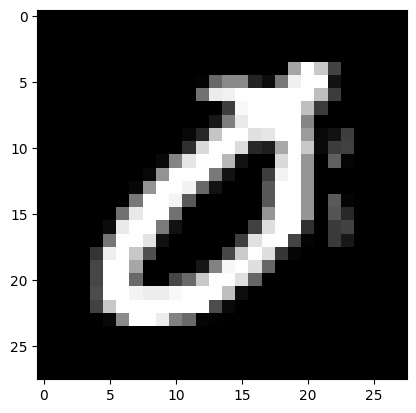

In [6]:
# ref: https://matplotlib.org/stable/tutorials/images.html
def display_img(img):
    pixels = img.reshape(28, 28)
    plt.imshow(pixels, cmap="gray")
    plt.show()
rando = np.random.randint(0, 60000)
display_img(train_imgs[rando])
plt.close("all")

In [7]:
def one_hot_vec(arr):
    v = np.zeros((arr.size, arr.max() + 1))
    v[np.arange(arr.size), arr] = 1
    return v
    
def normalize_images(imgs):
    imgs = imgs.reshape(imgs.shape[0], -1)
    imgs = imgs / 255 # normalize by largest RGB value
    data_mean = np.mean(imgs.ravel())
    data_std = np.std(imgs.ravel())
    imgs = (imgs - data_mean) / data_std   
    return imgs

def create_minibatches(batch_size, X, y):
    X, y = shuffle(X, y)
    m = X.shape[0]
    batches = []
    for i in range(0, m, batch_size):
        X_batch = X[i: i + batch_size]
        y_batch = y[i: i + batch_size]
        batches.append((X_batch, y_batch))
    return batches
        
def vectorize_labels(lbls):
    return one_hot_vec(lbls)


In [8]:
class ANN:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.optimizer = "sgd"
        self.batch_size = 32
        self.learning_rate = 1e-3
        self.input_dims = 784
        self.H1 = 100
        self.H2 = 80
        self.n_epochs = 20000
        self.n_out = 10
        self.W1 = np.random.rand(self.input_dims, self.H1) * (
            np.sqrt(2 / self.input_dims)  # Andrew Ng init
        )
        self.W2 = np.random.rand(self.H1, self.H2) * (np.sqrt(2 / self.H1))
        self.W3 = np.random.rand(self.H2, self.n_out) * (np.sqrt(2 / self.H2))
        self.b1 = np.zeros((1, self.H1))
        self.b2 = np.zeros((1, self.H2))
        self.b3 = np.zeros((1, self.n_out))
        self.rmsprop_buffer = {
            "W1": np.zeros_like(self.W1),
            "W2": np.zeros_like(self.W2),
            "W3": np.zeros_like(self.W3),
            "b1": np.zeros_like(self.b1),
            "b2": np.zeros_like(self.b2),
            "b3": np.zeros_like(self.b3),
        }

    def forward(self, X):
        # forward pass
        Z1 = np.dot(X, self.W1) + self.b1
        A1 = np.maximum(0, Z1)  # relu
        Z2 = np.dot(A1, self.W2) + self.b2
        A2 = np.maximum(0, Z2)  # relu
        Z3 = np.dot(A2, self.W3) + self.b3
        Z3 = Z3 - np.max(
            Z3, axis=-1, keepdims=True
        )  # applying norm due to nans, src: https://stackoverflow.com/questions/54880369/implementation-of-softmax-function-returns-nan-for-high-inputs
        A3 = np.exp(Z3) / np.sum(np.exp(Z3), axis=-1, keepdims=True)  # softmax
        return A1, A2, A3

    def backward(self, X, y, A1, A2, A3):
        # backward pass
        # l3
        dZ3 = A3 - y
        dW3 = (1 / X.shape[0]) * np.dot(A2.T, dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)
        # l2
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2.copy()
        dZ2[A2 < 0] = 0
        dW2 = (1 / X.shape[0]) * np.dot(A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)
        # l1
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1.copy()  # backprop relu
        dZ1[A1 < 0] = 0  # backprop relu
        dW1 = (1 / X.shape[0]) * np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)
        return dW1, db1, dW2, db2, dW3, db3

    def loss_fn(self, X, y, act_logits):
        L = -(1.0 / X.shape[0]) * np.sum(
            y * np.log(act_logits)
            + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
        )  # cost-entropy loss function (CE loss and natural log loss used interchangeably)
        return L

    def optimize(self, dW1, db1, dW2, db2, dW3, db3):
        # TODO: RMSProp does not work
        if self.optimizer == "rmsprop":
            # optimize with rmsprop
            self.rmsprop_buffer["W1"] = (
                0.9 * self.rmsprop_buffer["W1"] ** 2 + 0.1 * dW1**2
            )
            self.rmsprop_buffer["W2"] = (
                0.9 * self.rmsprop_buffer["W2"] ** 2 + 0.1 * dW2**2
            )
            self.rmsprop_buffer["W3"] = (
                0.9 * self.rmsprop_buffer["W3"] ** 2 + 0.1 * dW3**2
            )
            self.rmsprop_buffer["b1"] = (
                0.9 * self.rmsprop_buffer["b1"] ** 2 + 0.1 * db1**2
            )
            self.rmsprop_buffer["b2"] = (
                0.9 * self.rmsprop_buffer["b2"] ** 2 + 0.1 * db2**2
            )
            self.rmsprop_buffer["b3"] = (
                0.9 * self.rmsprop_buffer["b3"] ** 2 + 0.1 * db3**2
            )

            self.W1 -= (
                self.learning_rate / np.sqrt(self.rmsprop_buffer["W1"] + 0.00001)
            ) * dW1
            self.W2 -= (
                self.learning_rate / np.sqrt(self.rmsprop_buffer["W2"] + 0.00001)
            ) * dW2
            self.W3 -= (
                self.learning_rate / np.sqrt(self.rmsprop_buffer["W3"] + 0.00001)
            ) * dW3
            self.b1 -= (
                self.learning_rate / np.sqrt(self.rmsprop_buffer["b1"] + 0.00001)
            ) * db1
            self.b2 -= (
                self.learning_rate / np.sqrt(self.rmsprop_buffer["b2"] + 0.00001)
            ) * db2
            self.b3 -= (
                self.learning_rate / np.sqrt(self.rmsprop_buffer["b3"] + 0.00001)
            ) * db3
        else:
            # vanilla sgd
            self.W1 -= self.learning_rate * dW1
            self.W2 -= self.learning_rate * dW2
            self.W3 -= self.learning_rate * dW3
            self.b1 -= self.learning_rate * db1
            self.b2 -= self.learning_rate * db2
            self.b3 -= self.learning_rate * db3

    def train(self):
        losses = []
        mini_batches = create_minibatches(self.batch_size, self.X_train, self.y_train)
        for i in range(self.n_epochs):
            for X_train, y_train in mini_batches:
                A1, A2, A3 = self.forward(X_train)
                L = self.loss_fn(X_train, y_train, A3)
                dW1, db1, dW2, db2, dW3, db3 = self.backward(
                    X_train, y_train, A1, A2, A3
                )
                losses.append(L)
                self.optimize(dW1, db1, dW2, db2, dW3, db3)
            acc = self.test()
            print(f"epoch loss {i}: {L}, ", f"accuracy : {acc}")

        sns.lineplot(data=pd.DataFrame(losses, columns=["losses"]))
        plt.show()
        plt.close()

    def test(self):
        _, _, logits = self.forward(self.X_test)
        predicted = np.argmax(logits, axis=1, keepdims=True)
        target = np.argmax(self.y_test, axis=1, keepdims=True)
        accuracy = accuracy_score(target.ravel(), predicted.ravel())
        return accuracy

In [9]:
X_train = normalize_images(train_imgs)
y_train = vectorize_labels(train_lbls)
X_test = normalize_images(test_imgs)
y_test = vectorize_labels(test_lbls)
print(f"X_train.shape: {X_train.shape}")
print(f"Y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"Y_test.shape: {y_test.shape}")

model = ANN(X_train, y_train, X_test, y_test)
model.train()

X_train.shape: (60000, 784)
Y_train.shape: (60000, 10)
X_test.shape: (10000, 784)
Y_test.shape: (10000, 10)
epoch loss 0: 2.9258849289021516,  accuracy : 0.2803
epoch loss 1: 2.141636718632605,  accuracy : 0.589
epoch loss 2: 1.7756737860141731,  accuracy : 0.6871


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 3: 1.5251030858847954,  accuracy : 0.721


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 4: 1.3449144910120772,  accuracy : 0.7449


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 5: 1.2984117968695141,  accuracy : 0.7562


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 6: 1.4422157364551313,  accuracy : 0.7806


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 7: 1.4172777902668918,  accuracy : 0.7907


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 8: 1.4575273060205967,  accuracy : 0.7832


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 9: nan,  accuracy : 0.784


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 10: 1.33316498546956,  accuracy : 0.8063


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 11: 1.3958076482062836,  accuracy : 0.8087


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 12: 1.480615837763219,  accuracy : 0.8137


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 13: 1.5159914270159145,  accuracy : 0.8135


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 14: 1.5468262895845681,  accuracy : 0.8189


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 15: 1.906624584391714,  accuracy : 0.8214


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 16: 1.960793503831703,  accuracy : 0.8235


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 17: 1.9815599752001387,  accuracy : 0.823


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 18: 2.014281844089626,  accuracy : 0.8252


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 19: 2.0311972074316893,  accuracy : 0.827


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 20: 2.0113143531727053,  accuracy : 0.83


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 21: 1.976865117110794,  accuracy : 0.8321


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 22: 1.9385398935335965,  accuracy : 0.8341


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 23: 1.881090050108163,  accuracy : 0.8355


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 24: 1.821999158073656,  accuracy : 0.8366


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 25: 1.7601676576242413,  accuracy : 0.8375


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 26: 1.6934812401193877,  accuracy : 0.8396


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 27: 1.6276814028633053,  accuracy : 0.8415


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 28: 1.5592187546247969,  accuracy : 0.8423


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 29: 1.4881682461714676,  accuracy : 0.8441


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 30: 1.4172400722021643,  accuracy : 0.8452


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 31: 1.3502797061948404,  accuracy : 0.8453


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 32: 1.2885359803820151,  accuracy : 0.8446


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 33: 1.2364215452236786,  accuracy : 0.8442


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 34: 1.1919293016774473,  accuracy : 0.8428


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 35: 1.1597131777011054,  accuracy : 0.843


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 36: 1.1328313719897671,  accuracy : 0.8419


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 37: 1.1134713714862103,  accuracy : 0.8421


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 38: 1.0916362899930994,  accuracy : 0.8427


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 39: 1.0700884674896387,  accuracy : 0.8438
epoch loss 40: 1.047924365969952,  accuracy : 0.8454
epoch loss 41: 1.02757162022959,  accuracy : 0.8458
epoch loss 42: 1.0088911185250775,  accuracy : 0.8467
epoch loss 43: 0.9963415065201178,  accuracy : 0.847
epoch loss 44: 0.9848086435202834,  accuracy : 0.8483
epoch loss 45: 0.9666930843277454,  accuracy : 0.8487
epoch loss 46: 0.9542044051430025,  accuracy : 0.8496
epoch loss 47: 0.9481960972815707,  accuracy : 0.8503
epoch loss 48: 0.9456896744996589,  accuracy : 0.8505
epoch loss 49: 0.9438258095529253,  accuracy : 0.8516
epoch loss 50: 0.9411500246855664,  accuracy : 0.852
epoch loss 51: 0.9330512200362873,  accuracy : 0.8519
epoch loss 52: 0.9224498075447597,  accuracy : 0.8523
epoch loss 53: 0.9146229683295853,  accuracy : 0.8525
epoch loss 54: 0.9083028016009832,  accuracy : 0.8525
epoch loss 55: 0.9017345629075844,  accuracy : 0.8534
epoch loss 56: 0.8925611417407654,  accuracy : 0.8531
epoch loss 57: 0.8857746898910118

/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 334: 0.42914597577827385,  accuracy : 0.9273


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 335: 0.4293870987488284,  accuracy : 0.9278


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 336: 0.42960384074929403,  accuracy : 0.9278


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 337: 0.42992822717520507,  accuracy : 0.9279


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 338: 0.4303431715013944,  accuracy : 0.9278


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 339: 0.4306363820481916,  accuracy : 0.9279


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 340: 0.43090173343270277,  accuracy : 0.9279


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 341: 0.4311436396496674,  accuracy : 0.9276


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 342: 0.43133011136776045,  accuracy : 0.9273


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 343: 0.4314658588708701,  accuracy : 0.9274


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 344: 0.43152834937370943,  accuracy : 0.9273


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 345: 0.43159976673272527,  accuracy : 0.9272


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 346: 0.4316682698498803,  accuracy : 0.9272


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 347: 0.43170871536539984,  accuracy : 0.9275


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 348: 0.43178979883884777,  accuracy : 0.9276


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 349: 0.43188167762715635,  accuracy : 0.9275


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 350: 0.4318314206509638,  accuracy : 0.9277


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 351: 0.43179363357709244,  accuracy : 0.9276


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 352: 0.4319054403018019,  accuracy : 0.9274


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 353: 0.43200354694653026,  accuracy : 0.9274


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 354: 0.43218110792663184,  accuracy : 0.9274


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 355: 0.432482454665717,  accuracy : 0.9275


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 356: 0.43277657794477,  accuracy : 0.9276


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 357: 0.43293752904172444,  accuracy : 0.9275


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 358: 0.43277788797819416,  accuracy : 0.9276


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 359: 0.4326573898245994,  accuracy : 0.9278


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 360: 0.43249140863743973,  accuracy : 0.928


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 361: 0.43228482716552685,  accuracy : 0.9283


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 362: 0.43208764189742743,  accuracy : 0.9285


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 363: 0.43186879421110347,  accuracy : 0.9285


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 364: 0.43162129938403676,  accuracy : 0.9284


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 365: 0.43138800677089134,  accuracy : 0.9284


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 366: 0.4311257849810479,  accuracy : 0.9286


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 367: 0.4308269422375888,  accuracy : 0.9285


/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: divide by zero encountered in log
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)
/var/folders/f6/wq5mxjh56fn3n0322tvlpf700000gn/T/ipykernel_90208/1063372099.py:68: RuntimeWarning: invalid value encountered in multiply
  + (np.ones_like(y) - y) * np.log(np.ones_like(act_logits) - act_logits)


epoch loss 368: 0.4305543982489643,  accuracy : 0.9285
epoch loss 369: 0.4300943416549219,  accuracy : 0.9286
epoch loss 370: 0.42955531781035144,  accuracy : 0.9284
epoch loss 371: 0.42896193977833774,  accuracy : 0.9283
epoch loss 372: 0.42799989519714726,  accuracy : 0.9282
epoch loss 373: 0.42691237982265084,  accuracy : 0.9282
epoch loss 374: 0.4254671654516998,  accuracy : 0.9282
epoch loss 375: 0.4240100466292625,  accuracy : 0.9282
epoch loss 376: 0.42247647159522067,  accuracy : 0.9283
epoch loss 377: 0.42089774248491585,  accuracy : 0.9284
epoch loss 378: 0.4192637161886281,  accuracy : 0.9287
epoch loss 379: 0.417616492532275,  accuracy : 0.9287
epoch loss 380: 0.41596584052133223,  accuracy : 0.9286
epoch loss 381: 0.4143258069725924,  accuracy : 0.9289
epoch loss 382: 0.4127328788397207,  accuracy : 0.9289
epoch loss 383: 0.4111794286946066,  accuracy : 0.9289
epoch loss 384: 0.4096403311505159,  accuracy : 0.9292
epoch loss 385: 0.4080422588721417,  accuracy : 0.9289
epoc

KeyboardInterrupt: 